In [1]:
import pandas as pd
from collections import Counter
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
import requests
import folium
import geopandas as gpd
import json
from shapely.geometry import shape
# import set_matplotlib_hangul
import matplotlib.font_manager as fm
import warnings
warnings.filterwarnings('ignore')


#한글 설정
import platform
from matplotlib import font_manager, rc

get_ipython().run_line_magic("matplotlib", "inline")
# %matplotlib inline

path = "C:/Windows/Fonts/malgun.ttf"

if platform.system() == "Darwin":
    rc("font", family="Arial Unicode MS")
elif platform.system == "Windows":
    font_name = font_manager.Fontproperties(fname=path).get_name()
    rc("font", family=font_name)
else:
    print("Unkown system. sorry~~")



In [2]:
# CSV 파일 읽기
traveler_master = pd.read_csv("data/traveler_master_result.csv")
move = pd.read_csv("data/move_result.csv")
travel = pd.read_csv("data/travel_result.csv")
visit_area = pd.read_csv("data/visit_area_result.csv")

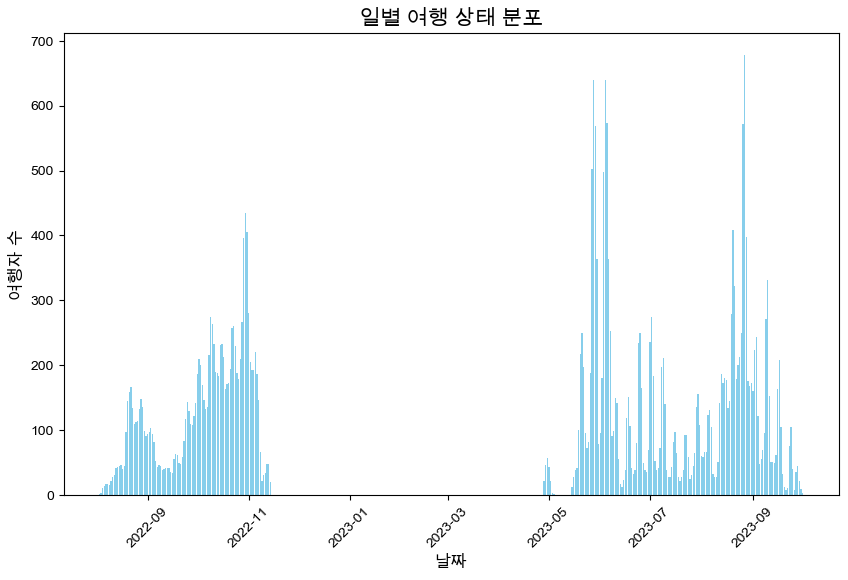

In [11]:
## 1. 여행자 특징 분석

# 일별 여행 건수 분포


travel['start_date'] = pd.to_datetime(travel['TRAVEL_START_YMD'])
travel['end_date'] = pd.to_datetime(travel['TRAVEL_END_YMD'])

# 모든 날짜 범위 생성
dates = pd.date_range(start=travel['start_date'].min(), end=travel['end_date'].max(), freq='D')

# 각 사람별 여행 일정을 일별 분리할 데이터프레임 생성
travel_day = pd.DataFrame(index=dates, columns=travel['TRAVELER_ID'])

# 각 사람의 여행 일정을 반복하며 일별 여행 상태 쪼개기
for index, row in travel.iterrows():
    start_date = row['start_date']
    end_date = row['end_date']
    travel_days = pd.date_range(start=start_date, end=end_date, freq='D')
    for travel_date in travel_days:
        travel_day.loc[travel_date, row['TRAVELER_ID']] = 1

# NaN 값을 0으로 채우기
travel_day = travel_day.fillna(0).astype(int)

# 각 날짜별로 여행자 수 계산
daily_counts = travel_day.sum(axis=1)

# 막대 그래프로 일별 여행 상태 분포 시각화
plt.figure(figsize=(10, 6))
plt.bar(daily_counts.index, daily_counts.values, color='skyblue')
plt.title('일별 여행 상태 분포', fontsize=15)
plt.xlabel('날짜', fontsize=12)
plt.ylabel('여행자 수', fontsize=12)
plt.xticks(rotation=45)

plt.show()

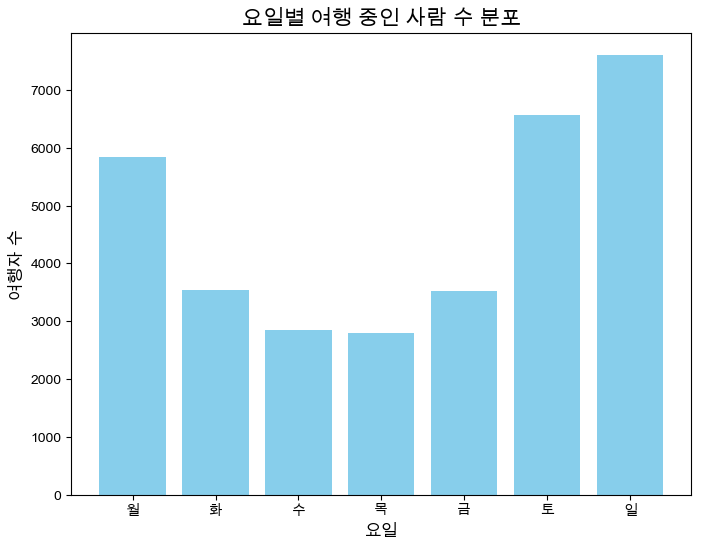

In [12]:
## 요일별 여행 분포

# 각 요일별로 여행 중인 사람 수 계산
weekly_counts = travel_day.groupby(travel_day.index.weekday).sum()

# 요일 이름 매핑
week_names = ['월', '화', '수', '목', '금', '토', '일']

# 막대 그래프로 요일별 여행 상태 분포 시각화
plt.figure(figsize=(8, 6))
plt.bar(week_names, weekly_counts.sum(axis=1), color='skyblue')
plt.title('요일별 여행 중인 사람 수 분포', fontsize=15)
plt.xlabel('요일', fontsize=12)
plt.ylabel('여행자 수', fontsize=12)
plt.xticks(rotation=0)
plt.show()

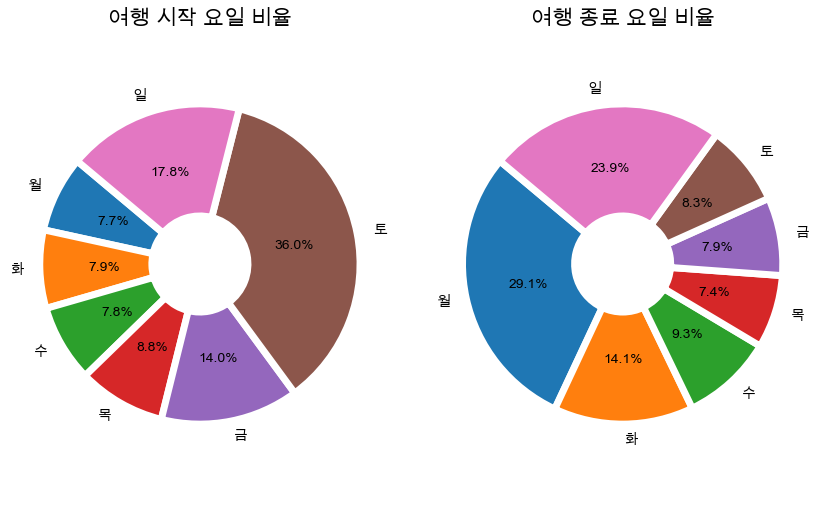

In [31]:
#시작 날짜에 따른 여행일별 분포

# 시작 날짜 여행 건수 계산
daily_travel_c = travel['start_date'].value_counts().sort_index()


# 전체 날짜 범위 생성
full_date = pd.date_range(start=daily_travel_c.index.min(), end=daily_travel_c.index.max())

# 데이터 프레임을 전체 날짜 범위 정렬 및 0 입력
daily_travel_c = daily_travel_c.reindex(full_date, fill_value=0)
daily_travel_c

# 시작 날짜의 요일별 여행 건수 계산
travel['start_day_of_week'] = travel['start_date'].dt.day_name()
week_counts = travel['start_day_of_week'].value_counts().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], fill_value=0)

# 요일 이름 매핑
week_names = ['월', '화', '수', '목', '금', '토', '일']

# 요일별 여행 건수 파이 차트
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

ax1.pie(week_counts, labels=week_names, autopct='%1.1f%%', startangle=140,wedgeprops=wedgeprops)
ax1.set_title('여행 시작 요일 비율', fontsize=15)
ax1.axis('equal')

#종료 날짜에 따른 여행일별 분포

# 종료 날짜 여행 건수 계산
daily_travel_end = travel['end_date'].value_counts().sort_index()

# 전체 날짜 범위 생성
full_date = pd.date_range(start=daily_travel_end.index.min(), end=daily_travel_end.index.max())

# 데이터 프레임을 전체 날짜 범위 정렬 및 0 입력
daily_travel_end = daily_travel_end.reindex(full_date, fill_value=0)
daily_travel_end

# 종료 날짜의 요일별 여행 건수 계산
travel['end_day_of_week'] = travel['end_date'].dt.day_name()
week_counts = travel['end_day_of_week'].value_counts().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], fill_value=0)


# 요일별 여행 건수 파이 차트
ax2.pie(week_counts, labels=week_names, autopct='%1.1f%%', startangle=140,wedgeprops=wedgeprops)
ax2.set_title('여행 종료 요일 비율', fontsize=15)
ax2.axis('equal')
plt.show()


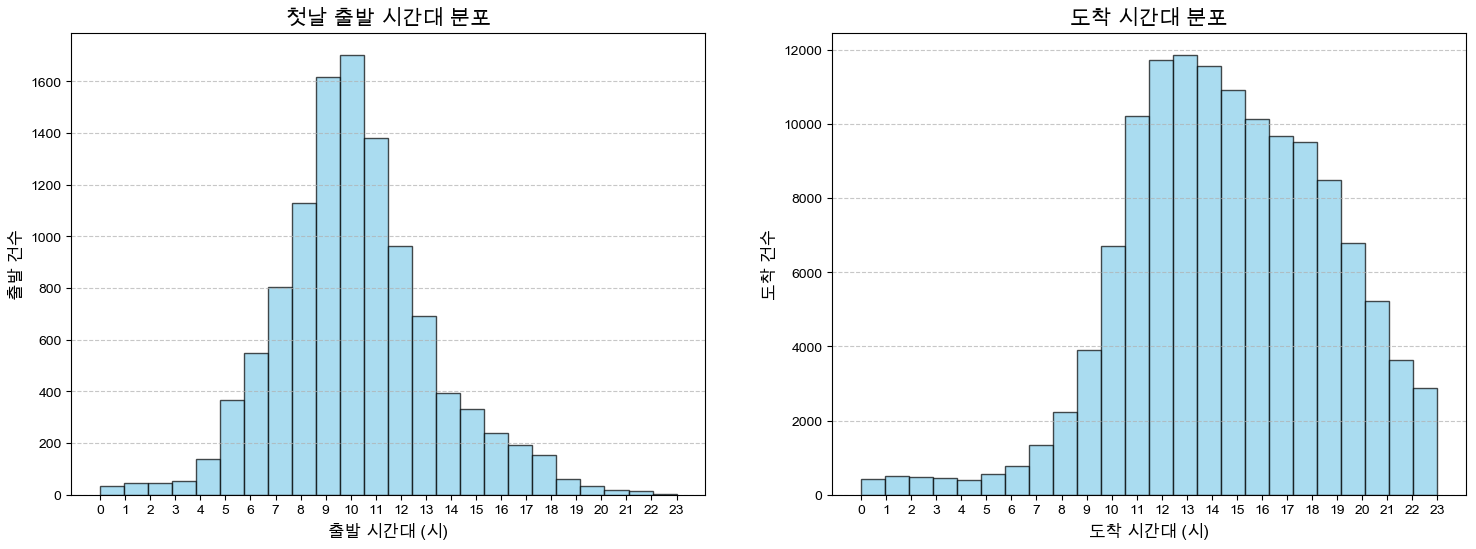

In [33]:
# 출발 시간대 분포
move_start = move.copy()
move_start = move_start.dropna(subset=['START_DT_MIN'])

# 마이크로초를 포함한 부분을 제거하고 초까지만 남기기
move_start['time_str'] = move_start['START_DT_MIN'].apply(lambda x: x[:16])
move_start.tail()

# datetime 변환
move_start['time_str'] = pd.to_datetime(move_start['time_str'])

# 출발 시간대 추출
move_start['start_hour'] = move_start['time_str'].dt.hour


# 도착 시간대 분포
move_end = move.copy()
move_end = move_end.dropna(subset=['END_DT_MIN'])

# 마이크로초를 포함한 부분을 제거하고 초까지만 남기기
move_end['time_end'] = move_end['END_DT_MIN'].apply(lambda x: x[:16])

# datetime 변환
move_end['time_end'] = pd.to_datetime(move_end['time_end'])

# 도착 시간대 추출
move_end['end_hour'] = move_end['time_end'].dt.hour

# 출발 시간대 분포 시각화
plt.figure(figsize=(18, 6))
plt.subplot(1,2,1)
plt.hist(move_start['start_hour'], bins=24, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('첫날 출발 시간대 분포', fontsize=15)
plt.xlabel('출발 시간대 (시)', fontsize=12)
plt.ylabel('출발 건수', fontsize=12)
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 도착 시간대 분포 시각화
plt.subplot(1,2,2)
plt.hist(move_end['end_hour'], bins=24, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('도착 시간대 분포', fontsize=15)
plt.xlabel('도착 시간대 (시)', fontsize=12)
plt.ylabel('도착 건수', fontsize=12)
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

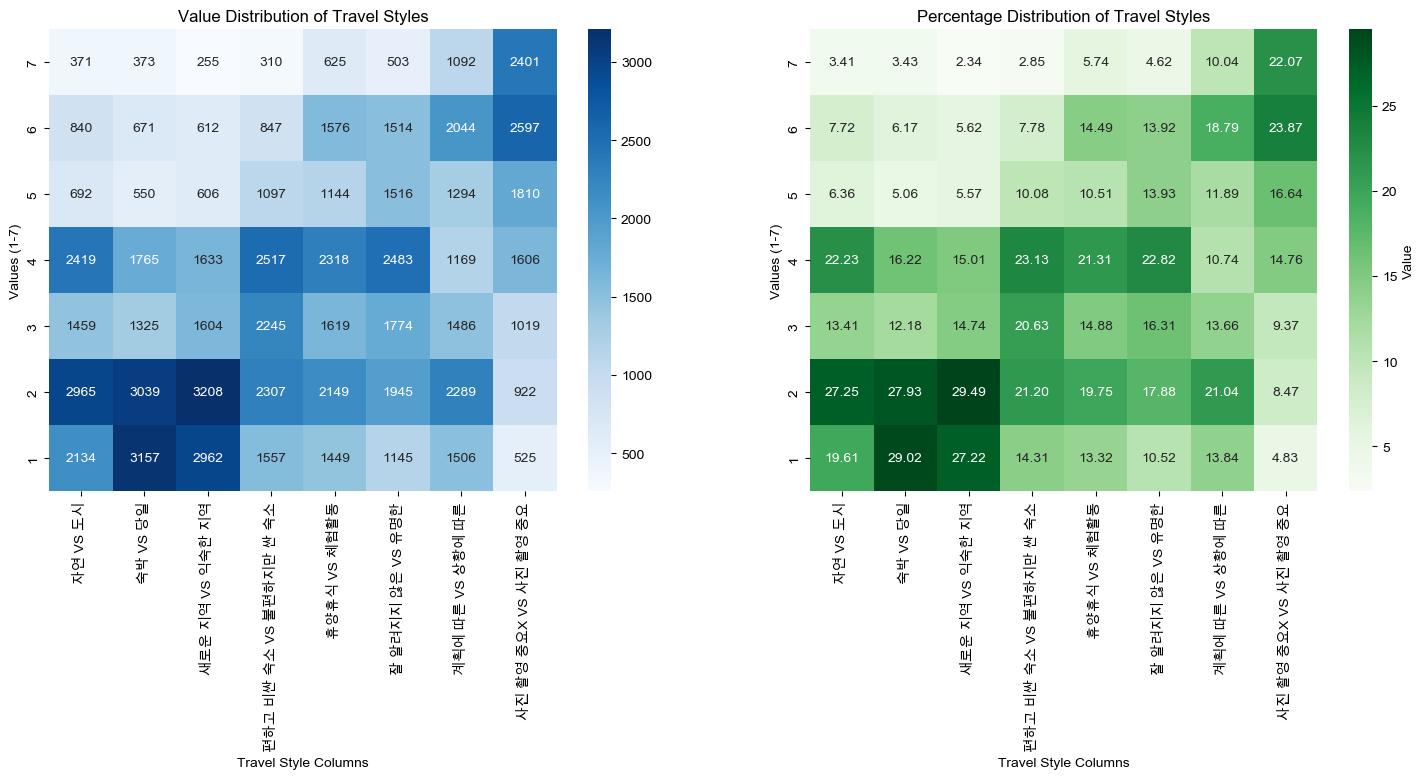

In [30]:
# TSY 별 분포도

# 각 칼럼별 값의 분포 계산
distribution = {}
percent_distribution = {}
traveler_TSY = traveler_master[['TRAVEL_STYL_1','TRAVEL_STYL_2','TRAVEL_STYL_3', 'TRAVEL_STYL_4', 'TRAVEL_STYL_5', 'TRAVEL_STYL_6', 'TRAVEL_STYL_7', 'TRAVEL_STYL_8']]
for column in traveler_TSY.columns:
    distribution[column] = traveler_TSY[column].value_counts().sort_index()
    percent_distribution[column] = traveler_TSY[column].value_counts(normalize=True).sort_index() * 100

distribution_df = pd.DataFrame(distribution).fillna(0).astype(int)
percent_df = pd.DataFrame(percent_distribution).fillna(0)
percent_df = percent_df.round(2)

# 칼럼 이름 변경
new_column_names = {
    'TRAVEL_STYL_1': '자연 VS 도시',
    'TRAVEL_STYL_2': '숙박 VS 당일',
    'TRAVEL_STYL_3': '새로운 지역 VS 익숙한 지역',
    'TRAVEL_STYL_4': '편하고 비싼 숙소 VS 불편하지만 싼 숙소',
    'TRAVEL_STYL_5': '휴양휴식 VS 체험활동',
    'TRAVEL_STYL_6': '잘 알려지지 않은 VS 유명한',
    'TRAVEL_STYL_7': '계획에 따른 VS 상황에 따른',
    'TRAVEL_STYL_8': '사진 촬영 중요X VS 사진 촬영 중요'
}

distribution_df.rename(columns=new_column_names, inplace=True)
percent_df.rename(columns=new_column_names, inplace=True)

# 히트맵으로 시각화
plt.figure(figsize=(18, 6))  # 가로 18, 세로 6으로 설정

plt.subplot(1,2,1)
# plt.figure(figsize=(5, 6))
sns.heatmap(distribution_df, annot=True, fmt='d', cmap='Blues')
plt.title('Value Distribution of Travel Styles')
plt.xlabel('Travel Style Columns')
plt.ylabel('Values (1-7)')
plt.gca().invert_yaxis()

plt.subplot(1,2,2)
# plt.figure(figsize=(10, 6))
sns.heatmap(percent_df, annot=True, fmt='.2f', cmap='Greens', cbar=True, cbar_kws={'label': 'Value'})
plt.title('Percentage Distribution of Travel Styles')
plt.xlabel('Travel Style Columns')
plt.ylabel('Values (1-7)')
plt.gca().invert_yaxis()


plt.show()

Chi-Square Statistic: 105.19686088958628, P-Value: 9.59804492879665e-15


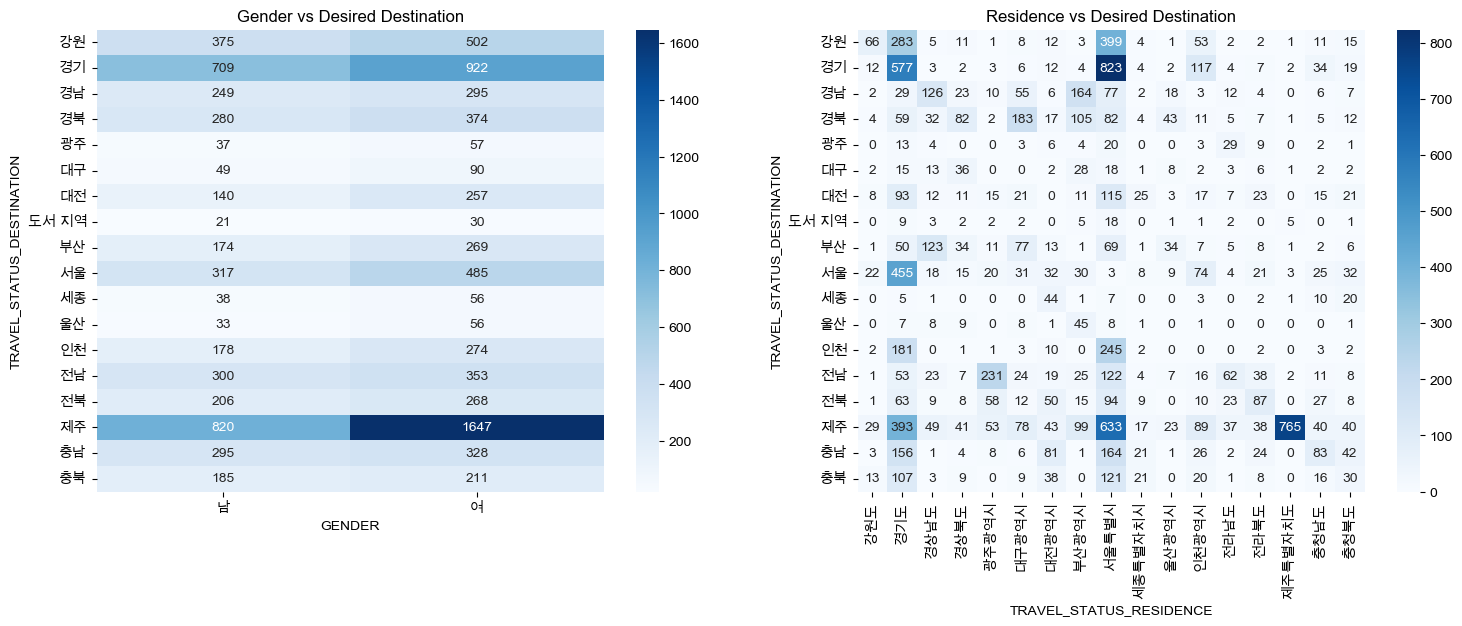

In [ ]:
## 상관관계 분석

import pandas as pd
from scipy.stats import chi2_contingency

# 범주형 데이터
traveler_corr = traveler_master[['GENDER', 'TRAVEL_STATUS_RESIDENCE', 'TRAVEL_STATUS_DESTINATION']]
# df = pd.DataFrame(data)

# 교차표 생성
cross_tab = pd.crosstab(traveler_corr['TRAVEL_STATUS_DESTINATION'], traveler_corr['GENDER'])
cross_tab_2 = pd.crosstab(traveler_corr['TRAVEL_STATUS_DESTINATION'], traveler_corr['TRAVEL_STATUS_RESIDENCE'])

# 카이제곱 검정
chi2, p, dof, expected = chi2_contingency(cross_tab)
print(f"Chi-Square Statistic: {chi2}, P-Value: {p}")

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 6))
plt.subplot(1,2,1)
sns.heatmap(cross_tab, annot=True, fmt='d', cmap='Blues')
plt.title('Gender vs Desired Destination')
plt.subplot(1,2,2)
sns.heatmap(cross_tab_2, annot=True, fmt='d', cmap='Blues')
plt.title('Residence vs Desired Destination')
plt.show()

TRAVEL_STATUS_DESTINATION   강원   경기   경남   경북  광주  대구   대전  도서 지역   부산   서울  \
AGE_GRP                                                                       
20                         283  506  140  220  46  51  191     12  169  378   
30                         250  586  178  200  24  53  134     25  145  249   
40                         210  313  125  129  18  23   46      9   84  109   
50                          96   80   74   79   3   8   20      4   33   23   
60                          38  146   27   26   3   4    6      1   12   43   

TRAVEL_STATUS_DESTINATION  세종  울산   인천   전남   전북   제주   충남   충북  
AGE_GRP                                                          
20                         24  29  162  234  181  999  177   89  
30                         37  29  169  205  142  916  204  129  
40                         23  14   80  109   83  413  127  100  
50                          8  11   19   85   59  113   86   64  
60                          2   6   22   20    9  

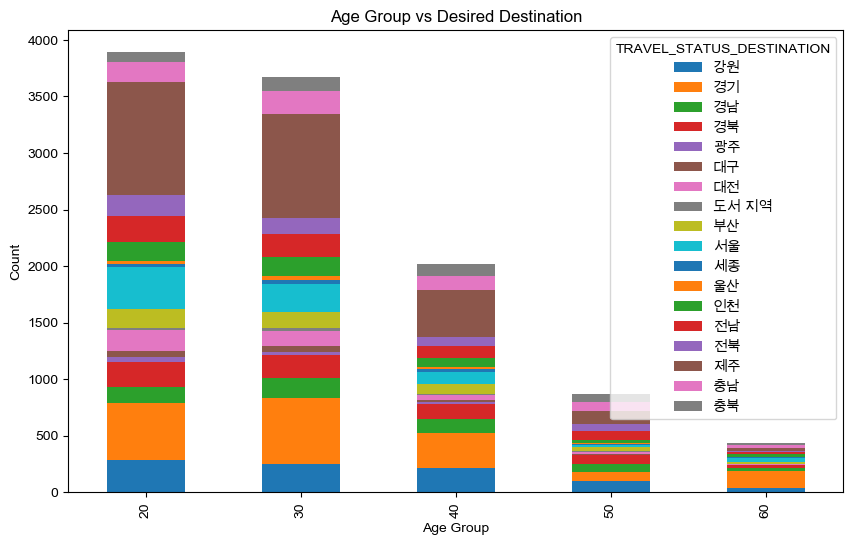

In [39]:
# 그룹화 후 빈도 계산
grouped = traveler_master.groupby(['AGE_GRP', 'TRAVEL_STATUS_DESTINATION']).size().unstack(fill_value=0)

# 결과 출력
print(grouped)

# 시각화: 바 플롯
grouped.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Age Group vs Desired Destination')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.show()

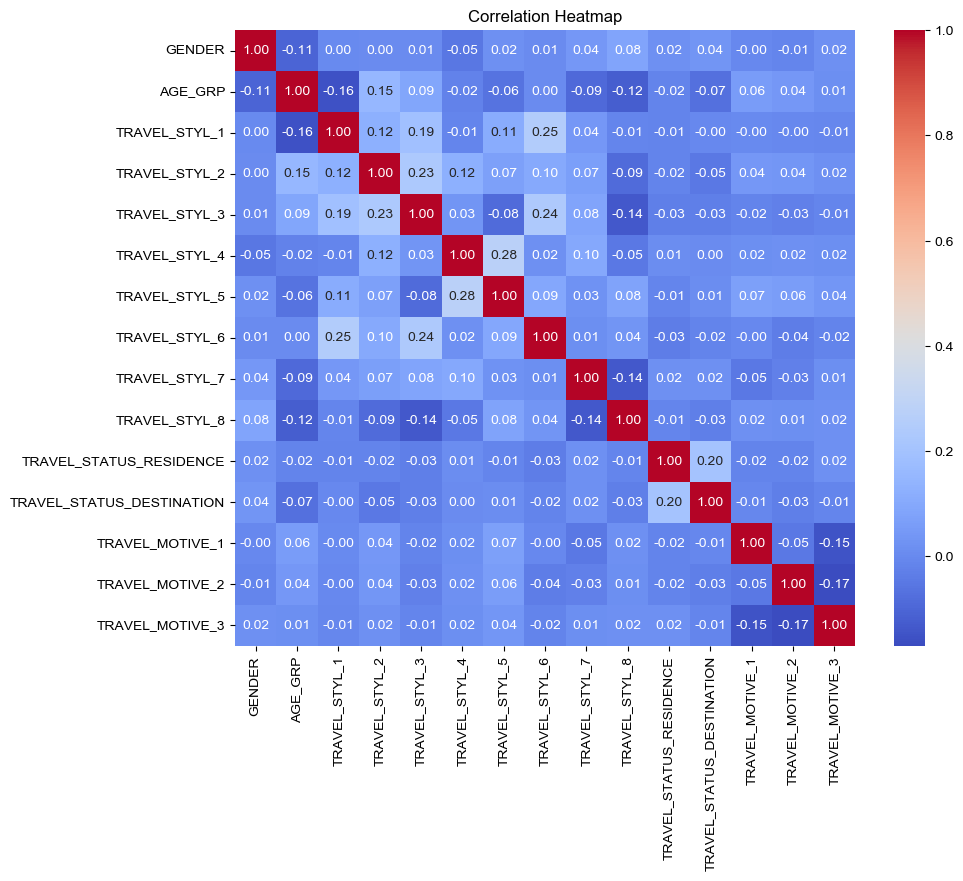

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder


traveler_df = traveler_master[['GENDER', 'AGE_GRP', 'TRAVEL_STYL_1', 'TRAVEL_STYL_2', 'TRAVEL_STYL_3', 'TRAVEL_STYL_4', 'TRAVEL_STYL_5', 
                               'TRAVEL_STYL_6', 'TRAVEL_STYL_7', 'TRAVEL_STYL_8', 'TRAVEL_STATUS_RESIDENCE', 'TRAVEL_STATUS_DESTINATION', 
                               'TRAVEL_MOTIVE_1', 'TRAVEL_MOTIVE_2', 'TRAVEL_MOTIVE_3']]
# 원-핫 인코딩
label_encoder = LabelEncoder()
df_encoded = traveler_df.apply(lambda col: label_encoder.fit_transform(col) if col.dtype == 'object' else col)

# 상관 행렬 계산
correlation_matrix = df_encoded.corr()

# 히트맵 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [46]:
traveler_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10880 entries, 0 to 10879
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   GENDER                     10880 non-null  object 
 1   AGE_GRP                    10880 non-null  int64  
 2   TRAVEL_STYL_1              10880 non-null  int64  
 3   TRAVEL_STYL_2              10880 non-null  int64  
 4   TRAVEL_STYL_3              10880 non-null  int64  
 5   TRAVEL_STYL_4              10880 non-null  int64  
 6   TRAVEL_STYL_5              10880 non-null  int64  
 7   TRAVEL_STYL_6              10880 non-null  int64  
 8   TRAVEL_STYL_7              10880 non-null  int64  
 9   TRAVEL_STYL_8              10880 non-null  int64  
 10  TRAVEL_STATUS_RESIDENCE    10880 non-null  object 
 11  TRAVEL_STATUS_DESTINATION  10880 non-null  object 
 12  TRAVEL_MOTIVE_1            10880 non-null  int64  
 13  TRAVEL_MOTIVE_2            10526 non-null  flo

In [50]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    # 교차표 생성
    confusion_matrix = pd.crosstab(x, y)
    chi2_stat, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2_stat / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))


# Cramér's V 계산
v = cramers_v(traveler_df['GENDER'], traveler_df['TRAVEL_STATUS_DESTINATION'])
print(f"카이제곱_성별: {v}")
v = cramers_v(traveler_df['TRAVEL_STATUS_RESIDENCE'], traveler_df['TRAVEL_STATUS_DESTINATION'])
print(f"카이제곱_거주지: {v}")
v = cramers_v(traveler_df['TRAVEL_MOTIVE_1'], traveler_df['TRAVEL_STATUS_DESTINATION'])
print(f"카이제곱_여행동기1: {v}")
v = cramers_v(traveler_df['TRAVEL_MOTIVE_2'], traveler_df['TRAVEL_STATUS_DESTINATION'])
print(f"카이제곱_여행동기2: {v}")
v = cramers_v(traveler_df['TRAVEL_MOTIVE_3'], traveler_df['TRAVEL_STATUS_DESTINATION'])
print(f"카이제곱_여행동기3: {v}")

카이제곱_성별: 0.09003849560796688
카이제곱_거주지: 0.2889280488827647
카이제곱_여행동기1: 0.06428403066089228
카이제곱_여행동기2: 0.04927453196176327
카이제곱_여행동기3: 0.044434148899595655


In [51]:
from scipy.stats import f_oneway

def eta_squared(x, y):
    groups = [y[x == category] for category in x.unique()]
    anova_result = f_oneway(*groups)
    ss_total = sum((y - y.mean())**2)
    ss_between = sum(len(group) * (group.mean() - y.mean())**2 for group in groups)
    return ss_between / ss_total


# Eta Squared 계산
eta = eta_squared(traveler_df['TRAVEL_STATUS_DESTINATION'], traveler_df['AGE_GRP'])
print(f"Eta Squared: {eta}")
eta = eta_squared(traveler_df['TRAVEL_STATUS_DESTINATION'], traveler_df['TRAVEL_STYL_1'])
print(f"Eta Squared: {eta}")
eta = eta_squared(traveler_df['TRAVEL_STATUS_DESTINATION'], traveler_df['TRAVEL_STYL_2'])
print(f"Eta Squared: {eta}")
eta = eta_squared(traveler_df['TRAVEL_STATUS_DESTINATION'], traveler_df['TRAVEL_STYL_3'])
print(f"Eta Squared: {eta}")
eta = eta_squared(traveler_df['TRAVEL_STATUS_DESTINATION'], traveler_df['TRAVEL_STYL_4'])
print(f"Eta Squared: {eta}")
eta = eta_squared(traveler_df['TRAVEL_STATUS_DESTINATION'], traveler_df['TRAVEL_STYL_5'])
print(f"Eta Squared: {eta}")
eta = eta_squared(traveler_df['TRAVEL_STATUS_DESTINATION'], traveler_df['TRAVEL_STYL_6'])
print(f"Eta Squared: {eta}")
eta = eta_squared(traveler_df['TRAVEL_STATUS_DESTINATION'], traveler_df['TRAVEL_STYL_7'])
print(f"Eta Squared: {eta}")
eta = eta_squared(traveler_df['TRAVEL_STATUS_DESTINATION'], traveler_df['TRAVEL_STYL_8'])
print(f"Eta Squared: {eta}")

Eta Squared: 0.031117771603738065
Eta Squared: 0.025012774545693624
Eta Squared: 0.013649088632875095
Eta Squared: 0.0049809708191793515
Eta Squared: 0.002117259355336681
Eta Squared: 0.002065102881649117
Eta Squared: 0.00511795947370247
Eta Squared: 0.007229563539977095
Eta Squared: 0.003839056229294851


In [55]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# 데이터 준비
X = traveler_df[['GENDER', 'AGE_GRP', 'TRAVEL_STYL_1', 'TRAVEL_STYL_2', 'TRAVEL_STYL_3', 'TRAVEL_STYL_4', 'TRAVEL_STYL_5', 
                'TRAVEL_STYL_6', 'TRAVEL_STYL_7', 'TRAVEL_STYL_8', 'TRAVEL_STATUS_RESIDENCE', 
                'TRAVEL_MOTIVE_1', 'TRAVEL_MOTIVE_2', 'TRAVEL_MOTIVE_3']]
y = traveler_df['TRAVEL_STATUS_DESTINATION']

# 인코딩
label_encoder = LabelEncoder()
X_encoded = X.apply(lambda col: label_encoder.fit_transform(col) if col.dtype == 'object' else col)


# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# 모델 학습
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# 변수 중요도 출력
importances = model.feature_importances_
feature_names = X_encoded.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)
print(importance_df)

                    Feature  Importance
10  TRAVEL_STATUS_RESIDENCE    0.139063
13          TRAVEL_MOTIVE_3    0.082340
6             TRAVEL_STYL_5    0.076548
9             TRAVEL_STYL_8    0.076412
5             TRAVEL_STYL_4    0.075847
8             TRAVEL_STYL_7    0.074597
7             TRAVEL_STYL_6    0.074362
12          TRAVEL_MOTIVE_2    0.072704
4             TRAVEL_STYL_3    0.067221
2             TRAVEL_STYL_1    0.065181
3             TRAVEL_STYL_2    0.062503
11          TRAVEL_MOTIVE_1    0.061299
1                   AGE_GRP    0.049300
0                    GENDER    0.022622


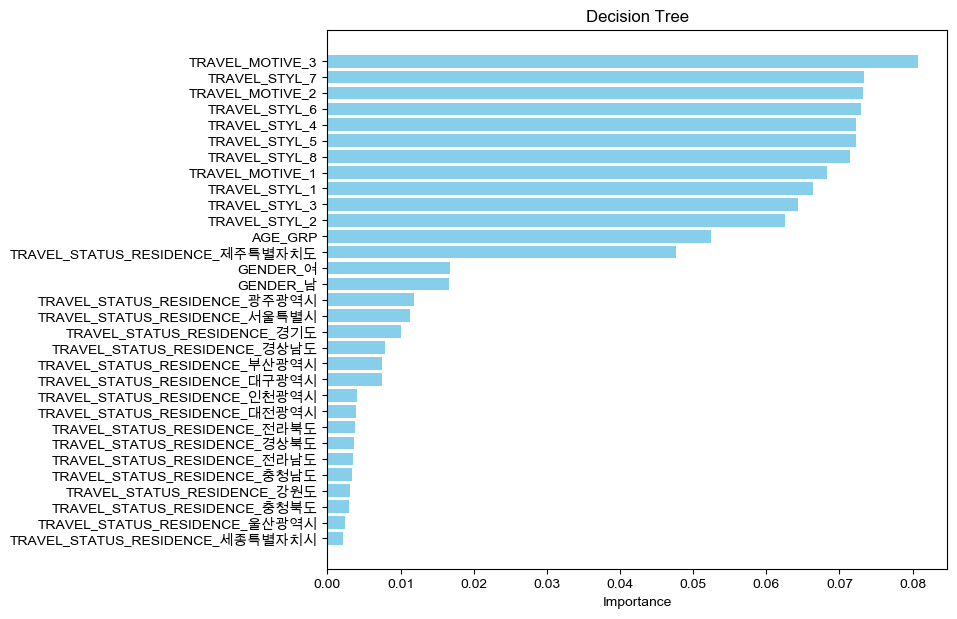

In [54]:

# 시각화
plt.figure(figsize=(8, 7))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Decision Tree')
plt.gca().invert_yaxis()  # 높은 중요도를 위로
plt.show()

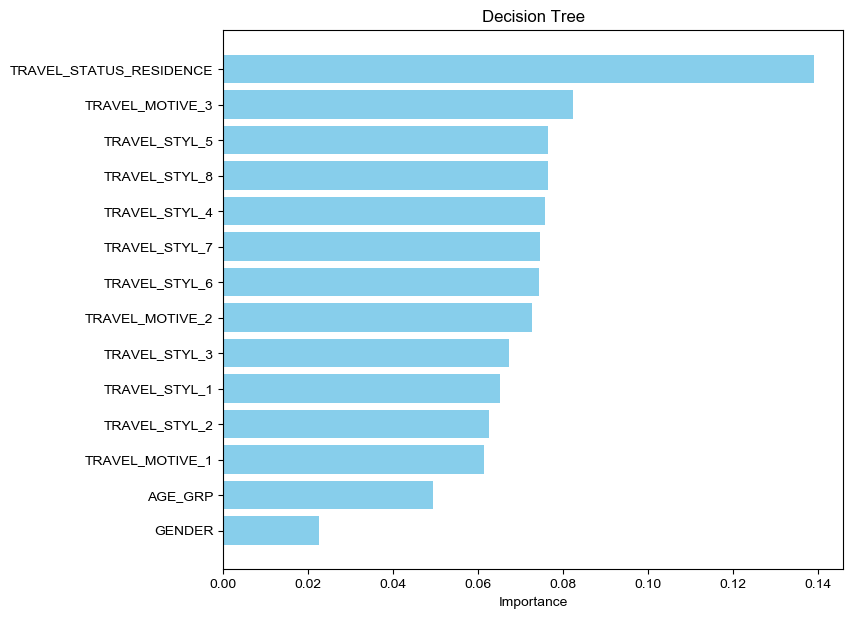

In [56]:

# 시각화
plt.figure(figsize=(8, 7))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Decision Tree')
plt.gca().invert_yaxis()  # 높은 중요도를 위로
plt.show()